### 查看库版本

In [21]:
#同样导入库并检查版本

from importlib.metadata import version

pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch" # For OpenAI's pretrained weights
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")


matplotlib version: 3.7.4
numpy version: 1.24.0
tiktoken version: 0.8.0
torch version: 2.4.0


### 使用未训练的GPT生成文本

In [ ]:
import torch
from gpt import GPTModel

# 定义GPT模型的配置参数
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # 词汇表大小
    "context_length": 256, # 缩短的上下文长度（原始值为1024）
    "emb_dim": 768,        # 嵌入维度
    "n_heads": 12,         # 注意力头的数量
    "n_layers": 12,        # 层数
    "drop_rate": 0.1,      # Dropout率
    "qkv_bias": False      # 查询-键-值偏置
}

# 设置随机种子，确保实验结果可复现
torch.manual_seed(123)

# 初始化GPT模型
model = GPTModel(GPT_CONFIG_124M)

# 将模型设置为评估模式，禁用Dropout（在推理时不需要Dropout）
model.eval()

In [36]:
from gpt import generate_text_simple
import torch
from transformers import GPT2Tokenizer

# 将文本转换为Token ID张量，并添加批次维度
def text_to_token_ids(text, tokenizer):
    # 使用tokenizer对文本进行编码，允许特殊token '<|endoftext|>'
    encoded = tokenizer.encode(text, add_special_tokens=True)
    # 将编码后的token ID转换为PyTorch张量，并添加批次维度
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

# 将Token ID张量转换回文本，移除批次维度
def token_ids_to_text(token_ids, tokenizer):
    # 移除批次维度，将张量从 (1, n) 变为 (n,)
    flat = token_ids.squeeze(0)
    # 使用tokenizer将token ID解码为文本
    return tokenizer.decode(flat.tolist())

# 设置初始上下文（中文例子）
start_context = "每一个努力都会让你"

# 初始化中文的分词器和模型

tokenizer = GPT2Tokenizer.from_pretrained("IDEA-CCNL/Wenzhong-GPT2-110M")

# 生成文本
token_ids = generate_text_simple(
    model=model,  # 假设已经定义并加载了GPT模型
    idx=text_to_token_ids(start_context, tokenizer),  # 将初始上下文转换为Token ID张量
    max_new_tokens=10,  # 生成的最大新token数量
    context_size=1024  # 上下文长度（假设 GPT_CONFIG_124M["context_length"] 为 1024）
)

# 将生成的Token ID转换回文本并打印
print("生成的文本:\n", token_ids_to_text(token_ids, tokenizer))

生成的文本:
 每一个努力都会让你，我也不敢


### 构造数据集

In [24]:
import os
import urllib.request

file_path = "红楼梦.txt"
#加载数据集
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [26]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
#统计一下文本的长度,编码文本内容并输出文本个数
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Token indices sequence length is longer than the specified maximum sequence length for this model (1861175 > 1024). Running this sequence through the model will result in indexing errors


Characters: 858628
Tokens: 1861175


In [27]:
from gpt import create_dataloader_v1
# 从一个库导入之前的文章

# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]
# 这边可以手动定义训练集跟测试集的比例

torch.manual_seed(123)
# 依旧保持可复现

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
# 初始化输入训练模型, 给出批处理的大小、给出最大文本容量防止溢出
# 给出步长, 丢弃最后一批不足的文本, 打开随机防止拟合过度

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)
# 初始化验证数据加载器, 给出批处理的大小、给出最大文本容量防止溢出
# 给出步长, 不丢弃最后一批不足的文本, 不进行随机打乱

### 定义损失函数

In [29]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    # 将输入数据和目标数据移动到指定的设备（如GPU）
    logits = model(input_batch)
    # 通过模型计算输入数据的输出（logits）
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    # 使用交叉熵损失函数计算损失，并将logits和目标数据展平为二维
    return loss
# 这是一个计算单个批次损失的函数

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    # 初始化总损失为0
    if len(data_loader) == 0:
        return float("nan")
        # 如果数据加载器为空，返回NaN（表示无效值）
    elif num_batches is None:
        num_batches = len(data_loader)
        # 如果未指定批次数，则使用数据加载器中的总批次数
    else:
        # 如果指定的批次数超过数据加载器中的总批次数，则将批次数减少到与数据加载器的总批次数匹配
        num_batches = min(num_batches, len(data_loader))
        # 减少需要处理的批次数，防止溢出
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            # 计算当前批次的损失
            total_loss += loss.item()
            # 将当前批次的损失累加到总损失中
        else:
            break
            # 如果已达到指定的批次数，则停止循环
    return total_loss / num_batches
    # 返回平均损失（总损失除以批次数）

#### 整体损失函数

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)  # 对于 nn.Module 类，不需要赋值 model = model.to(device)

torch.manual_seed(123)  # 固定随机种子，保证数据加载器打乱数据的结果可复现

with torch.no_grad():  # 禁用梯度跟踪以提高效率，因为此时尚未开始训练
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

# 推理阶段不计算梯度
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 11.029632693865826
Validation loss: 11.02708101802402


### 定义训练大模型流程

In [31]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # 初始化列表以跟踪损失和已处理的token数量
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    # 初始化训练模型并创建空列表用于记录数据

    # 主训练循环
    for epoch in range(num_epochs):  # 训练次数
        model.train()  # 将模型设置为训练模式
        # 切换到训练模式

        for input_batch, target_batch in train_loader:
            # 从数据加载器中获取输入和目标数据
            optimizer.zero_grad()  # 重置上一批次的梯度
            # 清空所有参数的梯度
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            # 计算当前批次的损失
            loss.backward()  # 计算损失梯度
            # 反向传播优化
            optimizer.step()  # 使用损失梯度更新模型权重
            # 更新模型权重
            tokens_seen += input_batch.numel()
            # 累加已处理的token数量
            global_step += 1
            # 记录全局训练步数

            # 可选的评估步骤
            if global_step % eval_freq == 0:
                # 按照指定的步数进行评估
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                # 计算训练和验证损失
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                # 将损失和已处理的token数量记录到列表中
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # 每个epoch结束后生成并打印一个样本文本
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen
    # 返回训练损失、验证损失和已处理的token数量


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    # 模型评估模块
    model.eval()  # 将模型设置为评估模式
    # 切换到评估模式
    with torch.no_grad():  # 禁用梯度计算
        # 确保在评估过程中不更新梯度
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
        # 计算训练和验证损失
    model.train()  # 评估结束后切换回训练模式
    # 在评估结束后切换回训练模式，确保模型能继续用于训练
    return train_loss, val_loss
    # 返回训练和验证损失


def generate_and_print_sample(model, tokenizer, device, start_context):
    # 生成并打印样本文本
    model.eval()  # 将模型设置为评估模式
    context_size = model.pos_emb.weight.shape[0]  # 获取模型的上下文大小
    encoded = text_to_token_ids(start_context, tokenizer).to(device)  # 将起始文本编码为token ID
    with torch.no_grad():  # 禁用梯度计算
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )  # 生成新的文本
    decoded_text = token_ids_to_text(token_ids, tokenizer)  # 将token ID解码为文本
    print(decoded_text.replace("\n", " "))  # 以紧凑格式打印生成的文本
    model.train()  # 切换回训练模式
    # 在生成文本后切换回训练模式，确保模型能继续用于训练

### 训练大模型

In [ ]:

torch.manual_seed(123)  # 设置随机种子，确保实验的可复现性
model = GPTModel(GPT_CONFIG_124M)  # 初始化GPT模型
model.to(device)  # 将模型移动到指定的设备（如GPU）
# 经典操作

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
# 使用AdamW优化器，其中学习率为0.0004，权重衰减为0.1
# 学习率控制参数更新的步幅，权重衰减用于防止过拟合

num_epochs = 10  # 设置训练的总轮数为10
# 10轮学习

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="贾宝玉", tokenizer=tokenizer
)


### 绘制损失函数

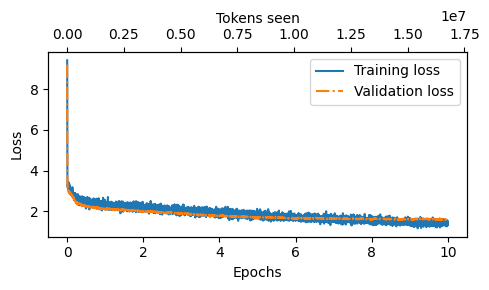

In [33]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    # 创建一个画布和子图，设置画布大小为 5x3
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # 绘制训练损失和验证损失随 epoch 变化的曲线
    ax1.plot(epochs_seen, train_losses, label="Training loss")  # 训练损失曲线
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")  # 验证损失曲线（虚线）
    ax1.set_xlabel("Epochs")  # 设置 x 轴标签为 "Epochs"
    ax1.set_ylabel("Loss")  # 设置 y 轴标签为 "Loss"
    ax1.legend(loc="upper right")  # 在右上角显示图例
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # 设置 x 轴刻度为整数

    # 创建第二个 x 轴，用于显示已处理的 token 数量
    ax2 = ax1.twiny()  # 创建一个共享 y 轴的第二个 x 轴
    ax2.plot(tokens_seen, train_losses, alpha=0)  # 绘制一个透明的曲线，用于对齐刻度
    ax2.set_xlabel("Tokens seen")  # 设置第二个 x 轴标签为 "Tokens seen"

    fig.tight_layout()  # 调整布局以避免元素重叠
    plt.savefig("loss-plot.pdf")  # 将图像保存为 PDF 文件
    plt.show()  # 显示图像

# 生成 epoch 的线性张量，用于绘制 x 轴
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
# 调用 plot_losses 函数，绘制损失曲线
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)
# 这是一个经典的绘图函数，用于可视化训练和验证损失

### 文本生成

In [44]:
model.to("cpu")
model.eval()



token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("贾宝玉", tokenizer),
    max_new_tokens=30,
    context_size=GPT_CONFIG_124M["context_length"]
)
#经典的载入
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 贾宝玉笑道：“我们这个东西，你们


### 温度缩放和top_k

In [45]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    # 生成模块
    # For-loop 与之前相同：获取 logits，并仅关注最后一个时间步
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]  # 截取最后的 context_size 个 token 作为输入
        with torch.no_grad():  # 禁用梯度计算
            logits = model(idx_cond)  # 通过模型计算 logits
        logits = logits[:, -1, :]  # 仅取最后一个时间步的 logits
        # 计算预测值，但只关注最后一个时间步

        # 新功能：使用 top-k 采样过滤 logits
        # top-k 采样
        if top_k is not None:
            # 仅保留 top_k 的值
            top_logits, _ = torch.topk(logits, top_k)  # 获取 top_k 的 logits
            min_val = top_logits[:, -1]  # 获取 top_k 的最小值
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)
            # 将小于 min_val 的 logits 设置为负无穷，排除低概率的 token

        # 新功能：应用温度缩放
        # 温度校正
        if temperature > 0.0:
            logits = logits / temperature  # 对 logits 进行温度缩放

            # 应用 softmax 获取概率分布
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # 从概率分布中采样下一个 token
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)
            # 从概率分布中采样下一个 token

        # 否则与之前相同：选择 logits 值最高的 token
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)
            # 如果未启用采样，选择概率最高的 token 作为下一个 token

        if idx_next == eos_id:  # 如果遇到结束符且 eos_id 已指定，则提前停止生成
            break

        # 与之前相同：将采样的 token 添加到当前序列中
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx  # 返回生成的完整序列

In [47]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("贾宝玉", tokenizer),
    max_new_tokens=20,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))
#经典的操作

Output text:
 贾宝玉不劝言，也不来请安�


#### 保留权重

In [48]:
torch.save(model.state_dict(), "model.pth")

#### 加载模型

In [ ]:
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval();